In [1]:
import h5py
import numpy as np
from scipy import signal

from matplotlib import pyplot as plt
import seaborn as sns

from pathlib import Path


In [2]:
data_dir = Path("./data/")
assert data_dir.is_dir()
intra_dir = data_dir / "Intra"
cross_dir = data_dir / "Cross"
intra_train_glob = list((intra_dir / "train").glob("*.h5"))
intra_test_glob = list((intra_dir / "test").glob("*.h5"))
len(intra_train_glob)

32

In [3]:
def load_labels(path: Path) -> np.ndarray:
    *task, subject_identifier, chunk = path.stem.split("_")
    if "rest" in task:
        y = 0
    elif 'math' in task:
        y = 1
    elif 'working' in task:
        y = 2
    elif 'motor' in task:
        y = 3
    else:
        assert False, 'unknown task'
    return np.array([y, int(subject_identifier), int(chunk)])

In [22]:
def downsample(data, old_freq, new_freq):
    # Calculate the downsampling factor
    downsample_factor = old_freq // new_freq

    # Check if the total samples are divisible by the downsampling factor
    # if data.shape[1] % downsample_factor != 0: # -> 2024
    #     print(f"Warning: The total samples ({data.shape[1]}) are not divisible by the downsampling factor ({downsample_factor}). The remaining {data.shape[1] % downsample_factor} samples will be discarded.")

    # Reshape the data to prepare for downsampling
    reshaped_data = data[:,:data.shape[1]//downsample_factor*downsample_factor].reshape(data.shape[0], -1, downsample_factor)

    # Perform the downsampling by taking the mean along the last axis
    downsampled_data = reshaped_data.mean(axis=-1)

    return downsampled_data

# Assuming 'data' is your MEG data
old_freq = 2400
new_freq = 1


In [23]:
def load_h5(path: Path) -> np.ndarray:
    with h5py.File(path) as f:
        keys = f.keys()
        assert len(keys) == 1, f"Only one key per file, right? {intra_train_glob[0]}"
        matrix = f.get(next(iter(keys)))[()]
    return downsample(matrix, old_freq, new_freq)


intra_train_X = np.stack(list(map(load_h5, intra_train_glob)))
intra_train_labels = np.stack(list(map(load_labels, intra_train_glob)))
intra_train_X.shape, intra_train_labels.shape

((32, 248, 14), (32, 3))

In [24]:
intra_test_X = np.stack(list(map(load_h5, intra_test_glob)))
intra_test_labels = np.stack(list(map(load_labels, intra_test_glob)))
intra_test_X.shape, intra_test_labels.shape

((8, 248, 14), (8, 3))

In [25]:

s = "0 0 0 0 0 0 0 0 0 0  121  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  122   90   89   120   152  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  123   91   62   61   88   119   151  0 0 0 0 0 0 0 0 0 0 0 0 0  124   92   63   38   37   60   87   118   150  0 0 0 0 0 0 0 0 0 0  177   153   93   64   39   20   19   36   59   86   117   149   176   195  0 0 0  229   212   178   154   126   94   65   40   21   6   5   18   35   58   85   116   148   175   194   228   248   230   213   179   155   127   95   66   41   22   7   4   17   34   57   84   115   147   174   193   227   247  0  231   196   156   128   96   67   42   23   8   3   16   33   56   83   114   146   173   211   246  0 0  232   197   157   129   97   68   43   24   9   2   15   32   55   82   113   145   172   210   245  0 0  233   198   158   130   98   69   44   25   10   1   14   31   54   81   112   144   171   209   244  0 0 0  214   180   131   99   70   45   26   11   12   13   30   53   80   111   143   192   226  0 0 0 0 0 0  159   132   100   71   46   27   28   29   52   79   110   142   170  0 0 0 0 0 0 0  181   160   133   101   72   47   48   49   50   51   78   109   141   169   191  0 0 0 0 0  215   199   182   161   134   102   73   74   75   76   77   108   140   168   190   208   225  0 0 0 0  234   216   200   183   162   135   103   104   105   106   107   139   167   189   207   224   243  0 0 0 0 0 0  235   217   201   184   163   136   137   138   166   188   206   223   242  0 0 0 0 0 0 0 0 0 0  236   218   202   185   164   165   187   205   222   241  0 0 0 0 0 0 0 0 0 0 0 0 0  219   203   186   204   221  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  237   220   240  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0  238   239  0 0 0 0 0 0 0 0 0 "
m_t = np.array(s.split(), dtype=int).reshape(20, 21)

# fig, ax = plt.subplots(figsize=(12, 10))
# sns.heatmap(m_t2, annot=True, fmt='')
# plt.show()

In [26]:
def reshape_data(data: np.ndarray) -> np.ndarray:
    reshaped_data = data[:, m_t - 1]
    reshaped_data[:, m_t == 0] = 0
    return reshaped_data
    

In [27]:
reshaped_train = reshape_data(intra_train_X)#= intra_train_X[:, m_t - 1]
# reshaped_train[:, m_t == 0] = 0
example = reshaped_train[0, ..., 0]
reshaped_train.shape, example.shape

((32, 20, 21, 14), (20, 21))

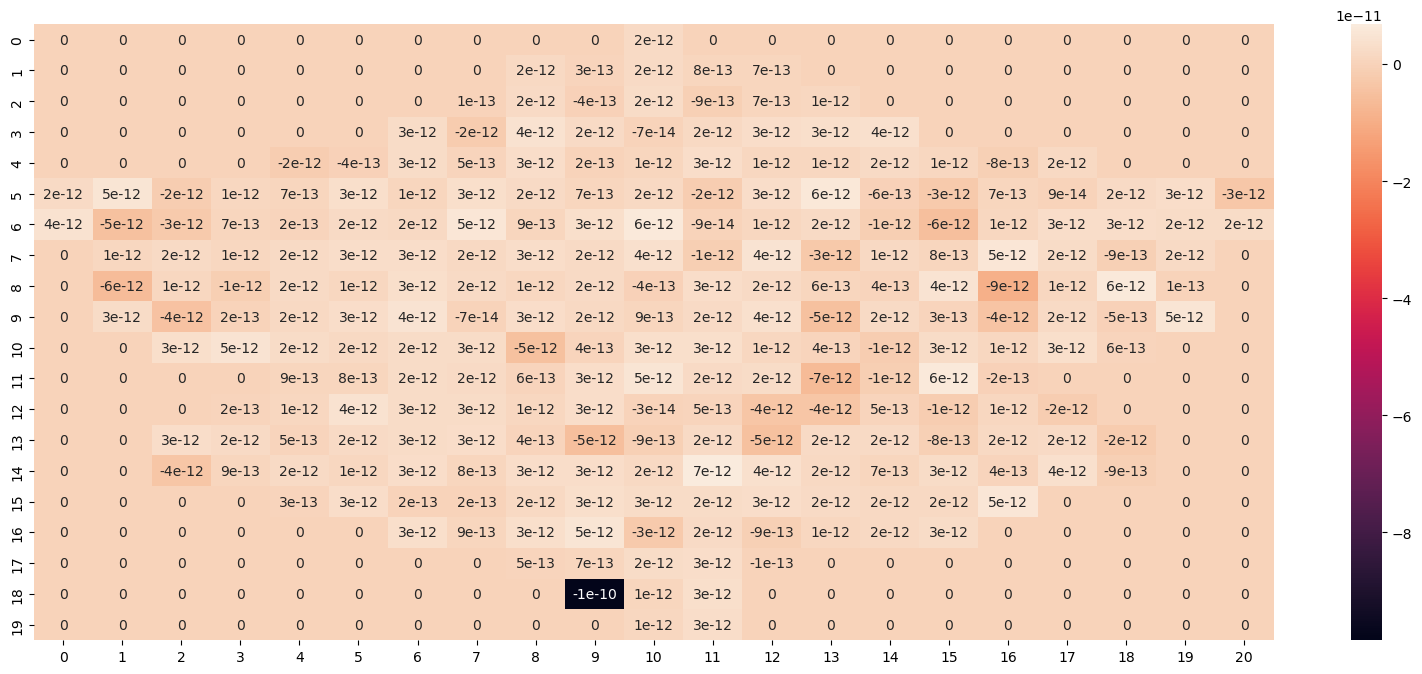

In [28]:
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(example, annot=True, fmt='.0g')
plt.show()